In [2]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ipl-complete-dataset-20082020/matches.csv
/kaggle/input/ipl-complete-dataset-20082020/deliveries.csv


In [3]:
import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [4]:
df_matches = pd.read_csv("/kaggle/input/ipl-complete-dataset-20082020/matches.csv")
df_deliveries = pd.read_csv("/kaggle/input/ipl-complete-dataset-20082020/deliveries.csv")

In [5]:
df_matches.head()

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [6]:
df_matches.shape

(1095, 20)

In [7]:

df_deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN


In [8]:
df_deliveries.shape

(260920, 17)

## Approaching the problem (Requirements)

To build the predictor, these are the features which we need.

* Batting Team
* Bowling Team
* City
* Runs left
* Balls left
* Wickets in hand
* Total run chase
* CRR
* RRR
* Result

This is a classification problem but we want to show the output in percentages, so, we'll use Logistic Regression or Support vector classifier. We'll train a classifer using the dataset and report the result in probabilities.

## Data Pre-processing

In [9]:
# finding the total_runs scored in each innings of each match
df_totalscore = df_deliveries.groupby(["match_id", "inning"]).sum()["total_runs"].reset_index()

In [10]:
df_totalscore

,match_id,inning,total_runs
0,335982,1,222
1,335982,2,82
2,335983,1,240
3,335983,2,207
4,335984,1,129
...,...,...,...
2212,1426310,2,174
2213,1426311,1,175
2214,1426311,2,139
2215,1426312,1,113


Our requirement is only the total_runs made in the 1st innings in each match (this is the chase by the second team).

In [11]:
df_totalscore = df_totalscore[df_totalscore["inning"] == 1]

In [12]:
df_totalscore

,match_id,inning,total_runs
0,335982,1,222
2,335983,1,240
4,335984,1,129
6,335985,1,165
8,335986,1,110
...,...,...,...
2207,1426307,1,214
2209,1426309,1,159
2211,1426310,1,172
2213,1426311,1,175


We'll merge this dataframe with the df_matches dataframe, since in the df_matches dataframe, we've the information of each match except the total_runs made in the 1st innings.

In [13]:
match_df = df_matches.merge(df_totalscore[["match_id", "total_runs"]], left_on = "id", right_on = "match_id")

In [14]:
match_df

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,...,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,match_id,total_runs
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,...,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,335982,222
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,...,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri,335983,240
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,...,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar,335984,129
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,...,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper,335985,165
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,...,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan,335986,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,1426307,2024,Hyderabad,2024-05-19,League,Abhishek Sharma,"Rajiv Gandhi International Stadium, Uppal, Hyd...",Punjab Kings,Sunrisers Hyderabad,Punjab Kings,...,wickets,4.0,215.0,20.0,N,NaN,Nitin Menon,VK Sharma,1426307,214
1091,1426309,2024,Ahmedabad,2024-05-21,Qualifier 1,MA Starc,"Narendra Modi Stadium, Ahmedabad",Sunrisers Hyderabad,Kolkata Knight Riders,Sunrisers Hyderabad,...,wickets,8.0,160.0,20.0,N,NaN,AK Chaudhary,R Pandit,1426309,159
1092,1426310,2024,Ahmedabad,2024-05-22,Eliminator,R Ashwin,"Narendra Modi Stadium, Ahmedabad",Royal Challengers Bengaluru,Rajasthan Royals,Rajasthan Royals,...,wickets,4.0,173.0,20.0,N,NaN,KN Ananthapadmanabhan,MV Saidharshan Kumar,1426310,172
1093,1426311,2024,Chennai,2024-05-24,Qualifier 2,Shahbaz Ahmed,"MA Chidambaram Stadium, Chepauk, Chennai",Sunrisers Hyderabad,Rajasthan Royals,Rajasthan Royals,...,runs,36.0,176.0,20.0,N,NaN,Nitin Menon,VK Sharma,1426311,175


In [15]:
match_df["team1"].unique()

array(['Royal Challengers Bangalore', 'Kings XI Punjab',
       'Delhi Daredevils', 'Mumbai Indians', 'Kolkata Knight Riders',
       'Rajasthan Royals', 'Deccan Chargers', 'Chennai Super Kings',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Gujarat Lions', 'Rising Pune Supergiants',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Lucknow Super Giants', 'Gujarat Titans',
       'Royal Challengers Bengaluru'], dtype=object)

In [16]:
# list of teams currently playing IPL
current_teams = [
    "Royal Challengers Bengaluru",
    "Mumbai Indians",
    "Chennai Super Kings",
    "Delhi Capitals",
    "Gujarat Titans",
    "Lucknow Super Giants",
    "Sunrisers Hyderabad",
    "Rajasthan Royals",
    "Punjab Kings",
    "Kolkata Knight Riders"
]

In [17]:

match_df["team1"] = match_df["team1"].str.replace("Delhi Daredevils", "Delhi Capitals")
match_df["team2"] = match_df["team2"].str.replace("Delhi Daredevils", "Delhi Capitals")
df_deliveries["batting_team"] = df_deliveries["batting_team"].str.replace("Delhi Daredevils", "Delhi Capitals")
df_deliveries["bowling_team"] = df_deliveries["bowling_team"].str.replace("Delhi Daredevils", "Delhi Capitals")

match_df["team1"] = match_df["team1"].str.replace("Deccan Chargers", "Sunrisers Hyderabad")
match_df["team2"] = match_df["team2"].str.replace("Deccan Chargers", "Sunrisers Hyderabad")
df_deliveries["batting_team"] = df_deliveries["batting_team"].str.replace("Deccan Chargers", "Sunrisers Hyderabad")
df_deliveries["bowling_team"] = df_deliveries["bowling_team"].str.replace("Deccan Chargers", "Sunrisers Hyderabad")

match_df["team1"] = match_df["team1"].str.replace("Royal Challengers Bangalore", "Royal Challengers Bengaluru")
match_df["team2"] = match_df["team2"].str.replace("Royal Challengers Bangalore", "Royal Challengers Bengaluru")
df_deliveries["batting_team"] = df_deliveries["batting_team"].str.replace("Royal Challengers Bangalore", "Royal Challengers Bengaluru")
df_deliveries["bowling_team"] = df_deliveries["bowling_team"].str.replace("Royal Challengers Bangalore", "Royal Challengers Bengaluru")


match_df["team1"] = match_df["team1"].str.replace("Kings XI Punjab", "Punjab Kings")
match_df["team2"] = match_df["team2"].str.replace("Kings XI Punjab", "Punjab Kings")
df_deliveries["batting_team"] = df_deliveries["batting_team"].str.replace("Kings XI Punjab", "Punjab Kings")
df_deliveries["bowling_team"] = df_deliveries["bowling_team"].str.replace("Kings XI Punjab", "Punjab Kings")

match_df["team1"] = match_df["team1"].str.replace("Gujarat Lions", "Gujarat Titans")
match_df["team2"] = match_df["team2"].str.replace("Gujarat Lions", "Gujarat Titans")
df_deliveries["batting_team"] = df_deliveries["batting_team"].str.replace("Gujarat Lions", "Gujarat Titans")
df_deliveries["bowling_team"] = df_deliveries["bowling_team"].str.replace("Gujarat Lions", "Gujarat Titans")

In [18]:
match_df = match_df[match_df["team1"].isin(current_teams)]
match_df = match_df[match_df["team2"].isin(current_teams)]
df_deliveries = df_deliveries[df_deliveries["batting_team"].isin(current_teams)]
df_deliveries = df_deliveries[df_deliveries["bowling_team"].isin(current_teams)]

In [19]:
match_df.columns

Index(['id', 'season', 'city', 'date', 'match_type', 'player_of_match',
       'venue', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner',
       'result', 'result_margin', 'target_runs', 'target_overs', 'super_over',
       'method', 'umpire1', 'umpire2', 'match_id', 'total_runs'],
      dtype='object')

In [20]:
df_deliveries.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs',
       'total_runs', 'extras_type', 'is_wicket', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

In [21]:
match_df = match_df[["match_id", "city", "total_runs", "winner"]]

In [22]:
deliveries_df = match_df.merge(df_deliveries, on = "match_id")

In [23]:
deliveries_df

,match_id,city,total_runs_x,winner,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs_y,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,Bangalore,222,Kolkata Knight Riders,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,Bangalore,222,Kolkata Knight Riders,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,Bangalore,222,Kolkata Knight Riders,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,Bangalore,222,Kolkata Knight Riders,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,Bangalore,222,Kolkata Knight Riders,1,Kolkata Knight Riders,Royal Challengers Bengaluru,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240042,1426312,Chennai,113,Kolkata Knight Riders,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,AK Markram,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN
240043,1426312,Chennai,113,Kolkata Knight Riders,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,AK Markram,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
240044,1426312,Chennai,113,Kolkata Knight Riders,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
240045,1426312,Chennai,113,Kolkata Knight Riders,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,Shahbaz Ahmed,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN


In [24]:
deliveries_df = deliveries_df[deliveries_df["inning"] == 2]

In [25]:
deliveries_df["city"] = deliveries_df["city"].str.replace("Bangalore", "Bengaluru")

In [26]:
deliveries_df

,match_id,city,total_runs_x,winner,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs_y,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
124,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN
125,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN
126,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN
127,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN
128,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240042,1426312,Chennai,113,Kolkata Knight Riders,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,AK Markram,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN
240043,1426312,Chennai,113,Kolkata Knight Riders,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,AK Markram,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
240044,1426312,Chennai,113,Kolkata Knight Riders,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
240045,1426312,Chennai,113,Kolkata Knight Riders,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,Shahbaz Ahmed,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN


We need to find runs_left and balls_left after each ball in the 2nd innings (our requirement)

In the deliveries_df above, total_runs_y will tell the total runs scored on that particular ball

In [27]:
deliveries_df["current_score"] = deliveries_df.groupby("match_id")["total_runs_y"].cumsum()

In [28]:
deliveries_df

,match_id,city,total_runs_x,winner,inning,batting_team,bowling_team,over,ball,batter,...,non_striker,batsman_runs,extra_runs,total_runs_y,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,current_score
124,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,1,R Dravid,...,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,1
125,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,2,W Jaffer,...,R Dravid,0,1,1,wides,0,NaN,NaN,NaN,2
126,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,3,W Jaffer,...,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,2
127,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,4,W Jaffer,...,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN,3
128,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,5,R Dravid,...,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240042,1426312,Chennai,113,Kolkata Knight Riders,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,...,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN,110
240043,1426312,Chennai,113,Kolkata Knight Riders,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,...,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN,111
240044,1426312,Chennai,113,Kolkata Knight Riders,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,...,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN,112
240045,1426312,Chennai,113,Kolkata Knight Riders,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,...,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN,113


In [29]:
deliveries_df.columns

Index(['match_id', 'city', 'total_runs_x', 'winner', 'inning', 'batting_team',
       'bowling_team', 'over', 'ball', 'batter', 'bowler', 'non_striker',
       'batsman_runs', 'extra_runs', 'total_runs_y', 'extras_type',
       'is_wicket', 'player_dismissed', 'dismissal_kind', 'fielder',
       'current_score'],
      dtype='object')

Target for 2nd innings chase => total_runs_x + 1

current score by 2nd innings batting team => current_score

So, runs_left to chase after every ball bowled => total_runs_x + 1 - current_score

In [30]:
deliveries_df["target_to_chase"] = deliveries_df["total_runs_x"] + 1 

In [31]:
deliveries_df["runs_left"] = deliveries_df["target_to_chase"] - deliveries_df["current_score"]

In [32]:
deliveries_df.head(14)

,match_id,city,total_runs_x,winner,inning,batting_team,bowling_team,over,ball,batter,...,extra_runs,total_runs_y,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,current_score,target_to_chase,runs_left
124,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,1,R Dravid,...,0,1,NaN,0,NaN,NaN,NaN,1,223,222
125,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,2,W Jaffer,...,1,1,wides,0,NaN,NaN,NaN,2,223,221
126,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,3,W Jaffer,...,0,0,NaN,0,NaN,NaN,NaN,2,223,221
127,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,4,W Jaffer,...,0,1,NaN,0,NaN,NaN,NaN,3,223,220
128,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,5,R Dravid,...,0,1,NaN,0,NaN,NaN,NaN,4,223,219
129,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,6,W Jaffer,...,0,0,NaN,0,NaN,NaN,NaN,4,223,219
130,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,7,W Jaffer,...,0,0,NaN,0,NaN,NaN,NaN,4,223,219
131,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,1,R Dravid,...,0,0,NaN,1,R Dravid,bowled,NaN,4,223,219
132,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,2,V Kohli,...,0,0,NaN,0,NaN,NaN,NaN,4,223,219
133,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,3,V Kohli,...,4,4,legbyes,0,NaN,NaN,NaN,8,223,215


Counting the balls_left column after every legal delivery (excluding wides/no balls).

In [33]:
# Create a column to identify legal deliveries (non-wide and non-no-ball)
deliveries_df["is_legal_delivery"] = ~deliveries_df["extras_type"].isin(["wides", "no_ball"])

# Calculate the cumulative count of legal balls bowled
deliveries_df["legal_balls_bowled"] = deliveries_df.groupby("match_id")["is_legal_delivery"].cumsum()

# Calculate balls left based on legal deliveries bowled
deliveries_df["balls_left"] = 120 - deliveries_df["legal_balls_bowled"]

In [34]:
deliveries_df.head(14)

,match_id,city,total_runs_x,winner,inning,batting_team,bowling_team,over,ball,batter,...,is_wicket,player_dismissed,dismissal_kind,fielder,current_score,target_to_chase,runs_left,is_legal_delivery,legal_balls_bowled,balls_left
124,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,1,R Dravid,...,0,NaN,NaN,NaN,1,223,222,True,1,119
125,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,2,W Jaffer,...,0,NaN,NaN,NaN,2,223,221,False,1,119
126,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,3,W Jaffer,...,0,NaN,NaN,NaN,2,223,221,True,2,118
127,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,4,W Jaffer,...,0,NaN,NaN,NaN,3,223,220,True,3,117
128,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,5,R Dravid,...,0,NaN,NaN,NaN,4,223,219,True,4,116
129,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,6,W Jaffer,...,0,NaN,NaN,NaN,4,223,219,True,5,115
130,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,7,W Jaffer,...,0,NaN,NaN,NaN,4,223,219,True,6,114
131,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,1,R Dravid,...,1,R Dravid,bowled,NaN,4,223,219,True,7,113
132,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,2,V Kohli,...,0,NaN,NaN,NaN,4,223,219,True,8,112
133,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,3,V Kohli,...,0,NaN,NaN,NaN,8,223,215,True,9,111


Now, we want wickets_left column as per our requirement.

In [35]:
deliveries_df.columns

Index(['match_id', 'city', 'total_runs_x', 'winner', 'inning', 'batting_team',
       'bowling_team', 'over', 'ball', 'batter', 'bowler', 'non_striker',
       'batsman_runs', 'extra_runs', 'total_runs_y', 'extras_type',
       'is_wicket', 'player_dismissed', 'dismissal_kind', 'fielder',
       'current_score', 'target_to_chase', 'runs_left', 'is_legal_delivery',
       'legal_balls_bowled', 'balls_left'],
      dtype='object')

In [36]:
# Cumulative count of wickets lost
deliveries_df["wickets_lost"] = deliveries_df.groupby("match_id")["is_wicket"].cumsum()

# Calculate wickets left
deliveries_df["wickets_left"] = 10 - deliveries_df["wickets_lost"]

In [37]:
deliveries_df.head(14)

,match_id,city,total_runs_x,winner,inning,batting_team,bowling_team,over,ball,batter,...,dismissal_kind,fielder,current_score,target_to_chase,runs_left,is_legal_delivery,legal_balls_bowled,balls_left,wickets_lost,wickets_left
124,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,1,R Dravid,...,NaN,NaN,1,223,222,True,1,119,0,10
125,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,2,W Jaffer,...,NaN,NaN,2,223,221,False,1,119,0,10
126,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,3,W Jaffer,...,NaN,NaN,2,223,221,True,2,118,0,10
127,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,4,W Jaffer,...,NaN,NaN,3,223,220,True,3,117,0,10
128,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,5,R Dravid,...,NaN,NaN,4,223,219,True,4,116,0,10
129,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,6,W Jaffer,...,NaN,NaN,4,223,219,True,5,115,0,10
130,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,7,W Jaffer,...,NaN,NaN,4,223,219,True,6,114,0,10
131,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,1,R Dravid,...,bowled,NaN,4,223,219,True,7,113,1,9
132,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,2,V Kohli,...,NaN,NaN,4,223,219,True,8,112,1,9
133,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,3,V Kohli,...,NaN,NaN,8,223,215,True,9,111,1,9


Now, we'll focus on crr, rrr, and result.

In [38]:
# crr = current_score/overs played till now
# balls played till now = 120 - balls_left
# overs played till now = balls played till now / 6
# hence, crr = (6 * current_score) / (120 - balls_left)
deliveries_df["crr"] = (6 * deliveries_df["current_score"]) / (120 - deliveries_df["balls_left"])

In [39]:
deliveries_df.head(14)

,match_id,city,total_runs_x,winner,inning,batting_team,bowling_team,over,ball,batter,...,fielder,current_score,target_to_chase,runs_left,is_legal_delivery,legal_balls_bowled,balls_left,wickets_lost,wickets_left,crr
124,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,1,R Dravid,...,NaN,1,223,222,True,1,119,0,10,6.000000
125,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,2,W Jaffer,...,NaN,2,223,221,False,1,119,0,10,12.000000
126,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,3,W Jaffer,...,NaN,2,223,221,True,2,118,0,10,6.000000
127,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,4,W Jaffer,...,NaN,3,223,220,True,3,117,0,10,6.000000
128,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,5,R Dravid,...,NaN,4,223,219,True,4,116,0,10,6.000000
129,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,6,W Jaffer,...,NaN,4,223,219,True,5,115,0,10,4.800000
130,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,7,W Jaffer,...,NaN,4,223,219,True,6,114,0,10,4.000000
131,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,1,R Dravid,...,NaN,4,223,219,True,7,113,1,9,3.428571
132,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,2,V Kohli,...,NaN,4,223,219,True,8,112,1,9,3.000000
133,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,3,V Kohli,...,NaN,8,223,215,True,9,111,1,9,5.333333


In [40]:
# rrr = runs_left / overs left
# overs_left = balls_left / 6
# hence, rrr = (6 * runs_left) / balls_left
deliveries_df["rrr"] = (6 * deliveries_df["runs_left"]) / deliveries_df["balls_left"]

In [41]:
deliveries_df.head(14)

,match_id,city,total_runs_x,winner,inning,batting_team,bowling_team,over,ball,batter,...,current_score,target_to_chase,runs_left,is_legal_delivery,legal_balls_bowled,balls_left,wickets_lost,wickets_left,crr,rrr
124,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,1,R Dravid,...,1,223,222,True,1,119,0,10,6.000000,11.193277
125,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,2,W Jaffer,...,2,223,221,False,1,119,0,10,12.000000,11.142857
126,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,3,W Jaffer,...,2,223,221,True,2,118,0,10,6.000000,11.237288
127,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,4,W Jaffer,...,3,223,220,True,3,117,0,10,6.000000,11.282051
128,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,5,R Dravid,...,4,223,219,True,4,116,0,10,6.000000,11.327586
129,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,6,W Jaffer,...,4,223,219,True,5,115,0,10,4.800000,11.426087
130,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,7,W Jaffer,...,4,223,219,True,6,114,0,10,4.000000,11.526316
131,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,1,R Dravid,...,4,223,219,True,7,113,1,9,3.428571,11.628319
132,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,2,V Kohli,...,4,223,219,True,8,112,1,9,3.000000,11.732143
133,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,3,V Kohli,...,8,223,215,True,9,111,1,9,5.333333,11.621622


Now, showing the result column in binary values (0 or 1).

In [42]:
def result(row):
    return 1 if row["winner"] == row["batting_team"] else 0

In [43]:
deliveries_df["result"] = deliveries_df.apply(result, axis = 1)

In [44]:
deliveries_df.head(14)

,match_id,city,total_runs_x,winner,inning,batting_team,bowling_team,over,ball,batter,...,target_to_chase,runs_left,is_legal_delivery,legal_balls_bowled,balls_left,wickets_lost,wickets_left,crr,rrr,result
124,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,1,R Dravid,...,223,222,True,1,119,0,10,6.000000,11.193277,0
125,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,2,W Jaffer,...,223,221,False,1,119,0,10,12.000000,11.142857,0
126,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,3,W Jaffer,...,223,221,True,2,118,0,10,6.000000,11.237288,0
127,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,4,W Jaffer,...,223,220,True,3,117,0,10,6.000000,11.282051,0
128,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,5,R Dravid,...,223,219,True,4,116,0,10,6.000000,11.327586,0
129,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,6,W Jaffer,...,223,219,True,5,115,0,10,4.800000,11.426087,0
130,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,0,7,W Jaffer,...,223,219,True,6,114,0,10,4.000000,11.526316,0
131,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,1,R Dravid,...,223,219,True,7,113,1,9,3.428571,11.628319,0
132,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,2,V Kohli,...,223,219,True,8,112,1,9,3.000000,11.732143,0
133,335982,Bengaluru,222,Kolkata Knight Riders,2,Royal Challengers Bengaluru,Kolkata Knight Riders,1,3,V Kohli,...,223,215,True,9,111,1,9,5.333333,11.621622,0


In [45]:
# Extracting the required columns and storing in final dataframe
df_final = deliveries_df[["batting_team", "bowling_team", "city", "runs_left", "balls_left", "wickets_left", "target_to_chase", "crr", "rrr", "result"]]

In [46]:
df_final.head()

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,target_to_chase,crr,rrr,result
124,Royal Challengers Bengaluru,Kolkata Knight Riders,Bengaluru,222,119,10,223,6.0,11.193277,0
125,Royal Challengers Bengaluru,Kolkata Knight Riders,Bengaluru,221,119,10,223,12.0,11.142857,0
126,Royal Challengers Bengaluru,Kolkata Knight Riders,Bengaluru,221,118,10,223,6.0,11.237288,0
127,Royal Challengers Bengaluru,Kolkata Knight Riders,Bengaluru,220,117,10,223,6.0,11.282051,0
128,Royal Challengers Bengaluru,Kolkata Knight Riders,Bengaluru,219,116,10,223,6.0,11.327586,0


In [47]:
df_final.shape

(115732, 10)

Shuffling df_final because every ball of a particular match appear consecutively and training would develop some bias.

In [48]:
df_final = df_final.sample(df_final.shape[0], random_state = 42)

In [49]:
df_final.head()

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,target_to_chase,crr,rrr,result
140264,Royal Challengers Bengaluru,Delhi Capitals,Delhi,77,52,8,182,9.264706,8.884615,0
197820,Mumbai Indians,Rajasthan Royals,Navi Mumbai,35,24,6,159,7.750000,8.750000,1
199234,Sunrisers Hyderabad,Delhi Capitals,Mumbai,173,83,8,208,5.675676,12.506024,0
143545,Kolkata Knight Riders,Sunrisers Hyderabad,Kolkata,109,85,9,175,11.314286,7.694118,0
31604,Punjab Kings,Rajasthan Royals,Chandigarh,153,100,10,184,9.300000,9.180000,0


In [50]:
df_final.sample()

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,target_to_chase,crr,rrr,result
180031,Mumbai Indians,Chennai Super Kings,Dubai,25,7,4,157,7.00885,21.428571,0


## Handling Missing Values

In [51]:
# Checking for any missing values
df_final.isnull().sum()

batting_team          0
bowling_team          0
city               6012
runs_left             0
balls_left            0
wickets_left          0
target_to_chase       0
crr                   0
rrr                  14
result                0
dtype: int64

In [52]:
df_final[df_final["rrr"].isnull()]

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,target_to_chase,crr,rrr,result
215124,Punjab Kings,Chennai Super Kings,Chennai,0,0,4,201,10.05,NaN,1
60854,Mumbai Indians,Chennai Super Kings,Mumbai,0,0,2,174,8.70,NaN,1
208955,Mumbai Indians,Delhi Capitals,Delhi,0,0,6,173,8.65,NaN,1
116734,Sunrisers Hyderabad,Punjab Kings,Chandigarh,0,0,7,180,9.00,NaN,1
179304,Mumbai Indians,Chennai Super Kings,Delhi,0,0,4,219,10.95,NaN,1
19356,Punjab Kings,Kolkata Knight Riders,Port Elizabeth,0,0,6,154,7.70,NaN,0
6618,Chennai Super Kings,Delhi Capitals,Delhi,0,0,4,188,9.40,NaN,1
57191,Chennai Super Kings,Rajasthan Royals,Chennai,0,0,7,147,7.35,NaN,1
138121,Sunrisers Hyderabad,Delhi Capitals,Hyderabad,0,0,7,164,8.20,NaN,1
134528,Rajasthan Royals,Mumbai Indians,Jaipur,0,0,3,168,8.40,NaN,1


In [53]:
# We can clearly see from above that when there are no balls left, rrr = NaN. So, replace all NaN values in 'rrr' column with zero
df_final["rrr"].fillna(0, inplace=True)

In [54]:
df_final.isnull().sum()

batting_team          0
bowling_team          0
city               6012
runs_left             0
balls_left            0
wickets_left          0
target_to_chase       0
crr                   0
rrr                   0
result                0
dtype: int64

In [55]:
df_final[df_final["city"].isnull()]

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,target_to_chase,crr,rrr,result
170573,Sunrisers Hyderabad,Royal Challengers Bengaluru,NaN,55,67,8,121,7.471698,4.925373,1
166455,Royal Challengers Bengaluru,Rajasthan Royals,NaN,170,109,10,178,4.363636,9.357798,0
166304,Delhi Capitals,Chennai Super Kings,NaN,20,10,5,180,8.727273,12.000000,1
166307,Delhi Capitals,Chennai Super Kings,NaN,18,7,5,180,8.601770,15.428571,1
165757,Punjab Kings,Royal Challengers Bengaluru,NaN,112,80,10,172,9.000000,8.400000,0
...,...,...,...,...,...,...,...,...,...,...
83726,Chennai Super Kings,Mumbai Indians,NaN,120,100,10,142,6.600000,7.200000,1
84423,Delhi Capitals,Mumbai Indians,NaN,58,52,9,126,6.000000,6.692308,0
163814,Rajasthan Royals,Delhi Capitals,NaN,94,36,4,185,6.500000,15.666667,0
160290,Rajasthan Royals,Punjab Kings,NaN,210,111,10,224,9.333333,11.351351,1


I use this criteria to fill the missing city values:

If the batting_team wins (result == 1), then assign the city of the batting_team to the unknown / missing city value. Else, assign the city of the bowling_team to the missing city value.

In [56]:
# Team-to-city mapping
team_city_map = {
    "Chennai Super Kings": "Chennai",
    "Mumbai Indians": "Mumbai",
    "Royal Challengers Bengaluru": "Bengaluru",
    "Sunrisers Hyderabad": "Hyderabad",
    "Delhi Capitals": "Delhi",
    "Punjab Kings": "Mohali",
    "Rajasthan Royals": "Jaipur",
    "Kolkata Knight Riders": "Kolkata",
    "Lucknow Super Giants" : "Lucknow",
    "Gujarat Titans" : "Ahmedabad"
}

In [57]:
# function to determine city based on winner
def fill_missing_city(match):
    if pd.isnull(match["city"]):  # Check if city is missing
        if match["result"] == 1:  # If batting team won
            return team_city_map.get(match["batting_team"])
        elif match["result"] == 0:  # If bowling team won
            return team_city_map.get(match["bowling_team"])
    return match["city"]  # If city is not missing, return the existing value

In [58]:
# Apply the function to fill missing values in the "city" column
df_final["city"] = df_final.apply(fill_missing_city, axis=1)

In [59]:
# Now, no null value should be remaining
df_final.isnull().sum() 

batting_team       0
bowling_team       0
city               0
runs_left          0
balls_left         0
wickets_left       0
target_to_chase    0
crr                0
rrr                0
result             0
dtype: int64

In [60]:
df_final[df_final["balls_left"] == 0]

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,target_to_chase,crr,rrr,result
230029,Mumbai Indians,Chennai Super Kings,Mumbai,21,0,4,207,9.30,inf,0
40415,Delhi Capitals,Sunrisers Hyderabad,Delhi,13,0,3,146,6.65,inf,0
230294,Royal Challengers Bengaluru,Sunrisers Hyderabad,Bengaluru,26,0,3,288,13.10,inf,0
123401,Delhi Capitals,Sunrisers Hyderabad,Hyderabad,16,0,5,192,8.80,inf,0
141662,Sunrisers Hyderabad,Royal Challengers Bengaluru,Bengaluru,15,0,7,219,10.20,inf,0
...,...,...,...,...,...,...,...,...,...,...
113625,Gujarat Titans,Punjab Kings,Rajkot,24,0,1,155,6.55,inf,0
164096,Punjab Kings,Kolkata Knight Riders,Abu Dhabi,3,0,5,165,8.10,inf,0
144826,Rajasthan Royals,Punjab Kings,Jaipur,20,0,1,185,8.25,inf,0
195439,Delhi Capitals,Rajasthan Royals,Mumbai,16,0,3,223,10.35,inf,0


In [61]:
df_final[df_final["crr"] == np.inf]

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,target_to_chase,crr,rrr,result
172136,Sunrisers Hyderabad,Royal Challengers Bengaluru,Abu Dhabi,131,120,10,132,inf,6.55,1
84117,Kolkata Knight Riders,Punjab Kings,Abu Dhabi,132,120,10,133,inf,6.60,0
22825,Mumbai Indians,Punjab Kings,Centurion,119,120,10,120,inf,5.95,1
73517,Kolkata Knight Riders,Chennai Super Kings,Chennai,196,120,10,201,inf,9.80,0
210570,Rajasthan Royals,Gujarat Titans,Ahmedabad,177,120,10,178,inf,8.85,1
...,...,...,...,...,...,...,...,...,...,...
221881,Gujarat Titans,Royal Challengers Bengaluru,Bengaluru,197,120,10,198,inf,9.85,1
15551,Punjab Kings,Royal Challengers Bengaluru,Durban,168,120,10,169,inf,8.40,0
110648,Sunrisers Hyderabad,Mumbai Indians,Hyderabad,142,120,10,143,inf,7.10,1
102407,Royal Challengers Bengaluru,Kolkata Knight Riders,Bengaluru,111,120,10,112,inf,5.55,0


So, we should remove those rows with balls_left = 0 / 120, so that neither 'crr' nor 'rrr' becomes infinite.

In [62]:
df_final = df_final[df_final["balls_left"] != 0] # Take those columns with balls_left != 0
df_final = df_final[df_final["balls_left"] != 120] # Take those columns with balls_left != 120

In [63]:
# Input features
X = df_final.iloc[:, :-1]
# Target Label
y = df_final.iloc[:, -1]

## Split the dataset into training and test sets

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [65]:
X_train.head()

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,target_to_chase,crr,rrr
177329,Royal Challengers Bengaluru,Chennai Super Kings,Mumbai,98,42,3,192,7.230769,14.000000
69755,Rajasthan Royals,Punjab Kings,Jaipur,51,51,7,125,6.434783,6.000000
72837,Kolkata Knight Riders,Punjab Kings,Kolkata,98,80,8,150,7.800000,7.350000
47749,Chennai Super Kings,Rajasthan Royals,Chennai,119,94,9,148,6.692308,7.595745
221499,Kolkata Knight Riders,Lucknow Super Giants,Kolkata,43,14,4,177,7.584906,18.428571


In [66]:
X_train.shape

(92208, 9)

In [67]:
y_train.head()

177329    0
69755     1
72837     1
47749     1
221499    0
Name: result, dtype: int64

In [68]:
y_train.shape

(92208,)

## One-Hot Encoding of non-numerical features

We can see that the column features - "batting_team", "bowling_team" & "city" are strings. So, we must apply One-Hot encoding onto them.

In [69]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

trf = ColumnTransformer([
    ("trf", OneHotEncoder(sparse_output = False, drop = "first"), [0, 1, 2])
], remainder = "passthrough")

## Pipeline for data transformation

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps = [
    ("step1", trf),
    ("step2", LogisticRegression(solver = "liblinear"))
])

## Model Training

In [71]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  [0, 1, 2])])),
                ('step2', LogisticRegression(solver='liblinear'))])

In [72]:
y_pred = pipe.predict(X_test)

In [73]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.8229297705287815

In [74]:
pipe.predict_proba(X_test)[4] # for match indexed 4

array([0.4839015, 0.5160985])

In [75]:
df_final.sample()

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,target_to_chase,crr,rrr,result
104894,Mumbai Indians,Chennai Super Kings,Chennai,11,7,6,159,7.858407,9.428571,1


In [76]:
deliveries_df.sample()

,match_id,city,total_runs_x,winner,inning,batting_team,bowling_team,over,ball,batter,...,target_to_chase,runs_left,is_legal_delivery,legal_balls_bowled,balls_left,wickets_lost,wickets_left,crr,rrr,result
72633,598030,Chennai,159,Chennai Super Kings,2,Chennai Super Kings,Sunrisers Hyderabad,12,4,MS Dhoni,...,160,67,True,76,44,2,8,7.342105,9.136364,1


In [77]:
# function to study matches
def match_progression(df, match_id, pipe):
    # taking out the particular match (with given match_id) from the entire dataframe
    current_match = df[df["match_id"] == match_id]
    # analyzing the match after every over
    current_match = current_match[current_match["ball"] == 6]
    # taking the required features of current_match into another temp_df
    temp_df = current_match[['batting_team','bowling_team','city','runs_left','balls_left','wickets_left','target_to_chase','crr','rrr']].dropna()
    # neither taking balls_left = 0 nor balls_left = 120 so that pipe.fit() runs ("crr"/"rrr" doesn't go infinite)
    temp_df = temp_df[temp_df['balls_left'] != 0]
    temp_df = temp_df[temp_df["balls_left"] != 120]
    # predicted probabilities
    prediction = pipe.predict_proba(temp_df)
    # create "lose" & "win" columns in temp_df
    temp_df['winning_prob'] = np.round(prediction.T[1]*100, 1)
    temp_df['losing_prob'] = np.round(prediction.T[0]*100, 1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    
    target = temp_df['target_to_chase'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets_left'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','winning_prob','losing_prob']]
    
    return temp_df, target

In [78]:
temp_df, target = match_progression(deliveries_df, 729279, pipe)
temp_df

Target- 164


,end_of_over,runs_after_over,wickets_in_over,winning_prob,losing_prob
80829,1,8,0,60.5,39.5
80835,2,1,0,54.6,45.4
80841,3,7,0,56.9,43.1
80847,4,1,0,52.0,48.0
80853,5,8,1,43.9,56.1
80859,6,7,0,45.9,54.1
80865,7,6,0,46.8,53.2
80871,8,3,1,33.3,66.7
80877,9,6,0,34.1,65.9
80883,10,7,0,35.8,64.2


Text(0.5, 1.0, 'Target-164')

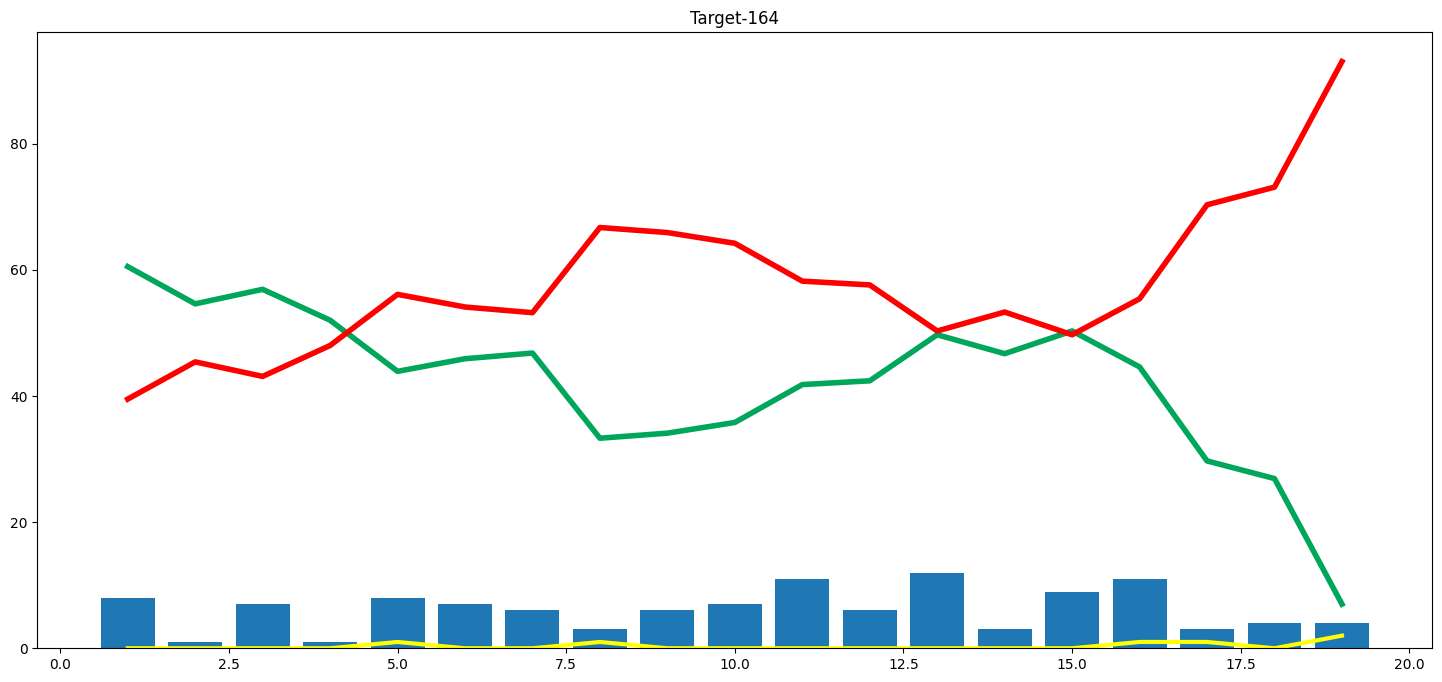

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['winning_prob'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['losing_prob'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))